# Integrated Analysis of Credit Risk and Capital Requirements

This notebook demonstrates how to use the `IntegratedAnalysis` class to integrate Monte Carlo simulations of credit risk with RWA calculators.

We will:
1. Import the required libraries and modules
2. Prepare the Freddie Mac mortgage dataset
3. Set up the Portfolio Simulator
4. Configure the RWA calculators (AIRB and SA)
5. Create and run multiple simulation scenarios
6. Compare the capital requirements across scenarios
7. Visualize the results

## 1. Import Required Libraries and Modules

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time

# Set plotting style
plt.style.use('ggplot')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

# IRBStudio modules
from irbstudio.simulation.portfolio_simulator import PortfolioSimulator
from irbstudio.engine.integrated_analysis import IntegratedAnalysis
from irbstudio.engine.mortgage.airb_calculator import AIRBMortgageCalculator
from irbstudio.engine.mortgage.sa_calculator import SAMortgageCalculator

## 2. Prepare the Freddie Mac Dataset

We'll use the sample Freddie Mac mortgage dataset that's included with IRBStudio. This dataset contains historical performance data for residential mortgages.

In [2]:
# Load the Freddie Mac sample data
# Define the columns we need
rating_col = 'rating'
loan_id_col = 'Loan_Sequence_Number'
date_col = 'reporting_date'
default_col = 'default_flag'
into_default_flag_col = 'into_default_flag'
score_col = 'score'
ltv_column = 'Estimated_Loan-to-Value_(ELTV)'
exposure_col = 'Current_Actual_UPB'

cols = [rating_col, loan_id_col, date_col, default_col, into_default_flag_col, score_col, ltv_column, exposure_col]
portfolio_df = pd.read_csv('../data/sample_portfolio_data_fm.csv', usecols=cols, parse_dates=[date_col])
portfolio_df['exposure'] = portfolio_df[exposure_col]
exposure_col = 'exposure'

# Display basic information about the dataset
print(f"Dataset shape: {portfolio_df.shape}")
print(f"Date range: {portfolio_df[date_col].min()} to {portfolio_df[date_col].max()}")
print(f"Number of unique loans: {portfolio_df[loan_id_col].nunique()}")

# Show a sample of the data
portfolio_df.head()

Dataset shape: (8711706, 9)
Date range: 2019-02-28 00:00:00 to 2025-03-31 00:00:00
Number of unique loans: 281792


,Loan_Sequence_Number,Current_Actual_UPB,Estimated_Loan-to-Value_(ELTV),default_flag,reporting_date,into_default_flag,score,rating,exposure
0,F19Q10000056,372000.0,999,0,2019-02-28,0.0,0.018109,3,372000.0
1,F19Q10000056,372000.0,999,0,2019-03-31,0.0,0.018097,3,372000.0
2,F19Q10000056,371000.0,999,0,2019-04-30,0.0,0.018086,3,371000.0
3,F19Q10000056,370000.0,999,0,2019-05-31,0.0,0.018074,3,370000.0
4,F19Q10000056,370000.0,75,0,2019-06-30,0.0,0.005479,2,370000.0


Rating distribution:
rating
1     3735027
2     2534012
3     2311416
4       25257
5       40597
6       16187
7          78
20      49132
dtype: int64

Number of defaulted observations: 49132
Default rate: 0.56%


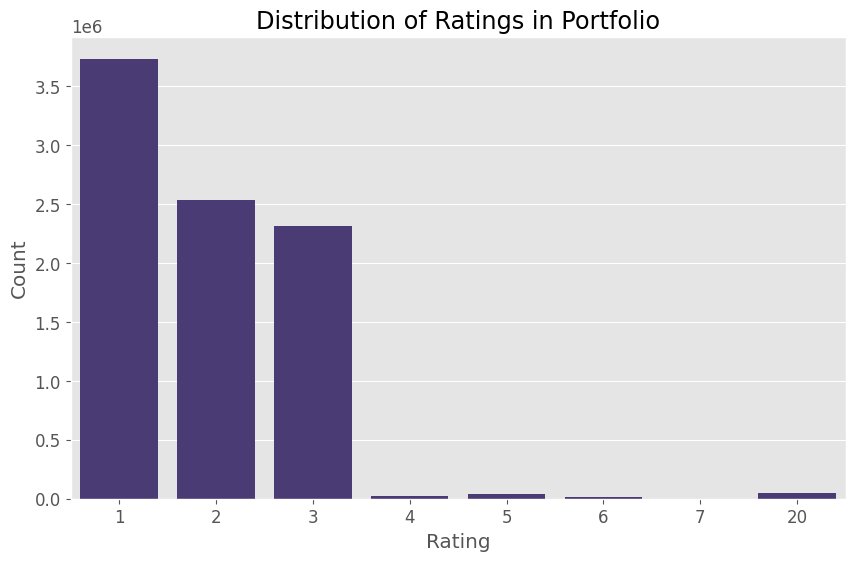

In [3]:
# Check the rating distribution
rating_counts = portfolio_df.groupby(rating_col).size()
print("Rating distribution:")
print(rating_counts)

# Check defaults in the portfolio
default_count = portfolio_df[portfolio_df[default_col] == 1].shape[0]
print(f"\nNumber of defaulted observations: {default_count}")
print(f"Default rate: {default_count / portfolio_df.shape[0]:.2%}")

# Create a simple visualization of rating distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=rating_col, data=portfolio_df)
plt.title('Distribution of Ratings in Portfolio')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

## 3. Set Up the Portfolio Simulator

Now we'll configure the `PortfolioSimulator` to run Monte Carlo simulations on our portfolio. We'll define the parameters for the simulation, including:

- Score-to-rating boundaries
- Application date for the simulation
- Asset correlation
- Target AUC for the simulated score

In [8]:
ltv_column = 'Estimated_Loan-to-Value_(ELTV)'
exposure_col = 'Current_Actual_UPB'

In [3]:
# Define the score-to-rating boundaries for Freddie Mac data
score_to_rating_bounds = {
    '1': (-1,0.003613294451497495),
    '2': (0.003613294451497495,0.005780360195785761),
    '3': (0.005780360195785761,0.03225071728229523),
    '4': (0.03225071728229523,0.039578670635819435),
    '5': (0.039578670635819435,0.256146103143692),
    '6': (0.256146103143692,0.7653337121009827),
    '7': (0.7653337121009827,50)
}

# Create a property value column for SA calculator (using LTV and exposure)
if 'property_value' not in portfolio_df.columns and ltv_column in portfolio_df.columns:
    portfolio_df['property_value'] = portfolio_df[exposure_col] / portfolio_df[ltv_column]
    
# Set up the application date (the date from which we want to project forward)
application_start_date = datetime(2024, 4, 1)

# Create baseline simulator
baseline_simulator = PortfolioSimulator(
    portfolio_df=portfolio_df,
    score_to_rating_bounds=score_to_rating_bounds,
    rating_col=rating_col,
    loan_id_col=loan_id_col,
    date_col=date_col,
    default_col=default_col,
    into_default_flag_col=into_default_flag_col,
    score_col=score_col,
    application_start_date=application_start_date,
    asset_correlation=0.15,  # Standard for mortgages
    target_auc=0.80,         # Baseline model performance
    random_seed=42           # For reproducibility
)

print("Preparing simulation...")
baseline_simulator.prepare_simulation()
print("Simulation preparation complete!")

# Quick verification of the prepared dataset
most_recent_data = baseline_simulator.application_df.copy()
print(f"\nApplication portfolio size: {most_recent_data.shape[0]} loans")
print(f"Application date: {application_start_date}")

Preparing simulation...
2025-09-30 10:10:50 - irbstudio.simulation.portfolio_simulator - INFO - Starting portfolio simulation preparation.
2025-09-30 10:10:50 - irbstudio.simulation.portfolio_simulator - INFO - Segmenting portfolio into historical and application samples.
2025-09-30 10:10:55 - irbstudio.simulation.portfolio_simulator - INFO - Fitting Beta Mixture Model to historical scores.
2025-09-30 10:10:56 - irbstudio.simulation.distribution - INFO - Supervised fitting complete.
2025-09-30 10:10:56 - irbstudio.simulation.distribution - INFO - Non-Default (C0): alpha=2.36, beta=431.43, weight=0.99
2025-09-30 10:10:56 - irbstudio.simulation.distribution - INFO - Default (C1): alpha=0.34, beta=4.50, weight=0.01
2025-09-30 10:10:56 - irbstudio.simulation.portfolio_simulator - INFO - Supervised fitting of Beta Mixture Model succeeded.
2025-09-30 10:10:56 - irbstudio.simulation.distribution - INFO - Searching for gamma to achieve target AUC of 0.8...
2025-09-30 10:10:56 - irbstudio.simul

## 4. Configure the RWA Calculators

Next, we'll set up our risk-weighted assets (RWA) calculators that will be used to evaluate capital requirements based on the simulation results:

1. **AIRB (Advanced Internal Ratings-Based)** - Uses the Basel III formula with internal PD estimates
2. **SA (Standardized Approach)** - Uses regulatory risk weights based on the loan-to-value ratio

In [4]:
# Configure AIRB calculator
airb_params = {
    'asset_correlation': 0.15,       # Standard for mortgages
    'confidence_level': 0.999,       # Basel III confidence level
    'lgd': 0.25,                     # Loss Given Default for mortgages
    'maturity_adjustment': False     # No maturity adjustment for mortgages
}

# Configure SA calculator
sa_params = {
    'secured_portion_rw': 0.20,      # 20% risk weight for secured portion
    'unsecured_portion_rw': 0.75,    # 75% risk weight for unsecured portion
    'property_value_threshold': 0.55  # 55% of property value threshold
}

# Create calculator instances
airb_calculator = AIRBMortgageCalculator(airb_params)
sa_calculator = SAMortgageCalculator(sa_params)

print("RWA calculators configured successfully!")

RWA calculators configured successfully!


## 5. Create and Run Multiple Simulation Scenarios

Now we'll set up the `IntegratedAnalysis` framework to run multiple scenarios and compare the results.

We'll create three different scenarios:
1. **Baseline** - Using our standard parameters
2. **High AUC** - Simulating a more powerful risk model (higher discrimination)
3. **Low Correlation** - Simulating a lower asset correlation environment

In [5]:
# Create the IntegratedAnalysis instance
integrated_analysis = IntegratedAnalysis()

# Add the calculators
integrated_analysis.add_calculator('AIRB', airb_calculator)
integrated_analysis.add_calculator('SA', sa_calculator)

# Add the baseline scenario
integrated_analysis.add_scenario(
    'Baseline',
    baseline_simulator,
    n_iterations=2,  # For demonstration purposes, you might want to use more in practice
    description="Baseline scenario with standard parameters"
)

# Create a high-AUC scenario (better risk differentiation)
high_auc_simulator = PortfolioSimulator(
    portfolio_df=portfolio_df.copy(),
    score_to_rating_bounds=score_to_rating_bounds,
    rating_col=rating_col,
    loan_id_col=loan_id_col,
    date_col=date_col,
    default_col=default_col,
    into_default_flag_col=into_default_flag_col,
    score_col=score_col,
    application_start_date=application_start_date,
    asset_correlation=0.15,
    target_auc=0.90,  # Higher AUC means better risk discrimination
    random_seed=42
)
high_auc_simulator.prepare_simulation()

# Add the high AUC scenario
integrated_analysis.add_scenario(
    'High AUC (0.90)',
    high_auc_simulator,
    n_iterations=2,
    description="Improved model performance with AUC of 0.90"
)

# Create a low-correlation scenario
low_corr_simulator = PortfolioSimulator(
    portfolio_df=portfolio_df.copy(),
    score_to_rating_bounds=score_to_rating_bounds,
    rating_col=rating_col,
    loan_id_col=loan_id_col,
    date_col=date_col,
    default_col=default_col,
    into_default_flag_col=into_default_flag_col,
    score_col=score_col,
    application_start_date=application_start_date,
    asset_correlation=0.15,  # Lower correlation
    target_auc=0.70,         # Same AUC as baseline
    random_seed=42
)
low_corr_simulator.prepare_simulation()

# Add the low correlation scenario
integrated_analysis.add_scenario(
    'Low Correlation (0.15)',
    low_corr_simulator,
    n_iterations=2,
    description="Lower asset correlation environment"
)

print("All scenarios added successfully!")

2025-09-30 10:12:00 - irbstudio.simulation.portfolio_simulator - INFO - Starting portfolio simulation preparation.
2025-09-30 10:12:00 - irbstudio.simulation.portfolio_simulator - INFO - Segmenting portfolio into historical and application samples.
2025-09-30 10:12:03 - irbstudio.simulation.portfolio_simulator - INFO - Fitting Beta Mixture Model to historical scores.
2025-09-30 10:12:04 - irbstudio.simulation.distribution - INFO - Supervised fitting complete.
2025-09-30 10:12:04 - irbstudio.simulation.distribution - INFO - Non-Default (C0): alpha=2.36, beta=431.43, weight=0.99
2025-09-30 10:12:04 - irbstudio.simulation.distribution - INFO - Default (C1): alpha=0.34, beta=4.50, weight=0.01
2025-09-30 10:12:04 - irbstudio.simulation.portfolio_simulator - INFO - Supervised fitting of Beta Mixture Model succeeded.
2025-09-30 10:12:04 - irbstudio.simulation.distribution - INFO - Searching for gamma to achieve target AUC of 0.9...
2025-09-30 10:12:04 - irbstudio.simulation.distribution - INF

In [ ]:
# Run the scenarios with memory-efficient processing (important for large datasets)
print("Running baseline scenario with memory-efficient processing...")
start_time = time.time()
baseline_results = integrated_analysis.run_scenario('Baseline', memory_efficient=True, process_all_dates=True)
print(f"Baseline scenario completed in {time.time() - start_time:.2f} seconds")

print("\nRunning high AUC scenario with memory-efficient processing...")
start_time = time.time()
high_auc_results = integrated_analysis.run_scenario('High AUC (0.90)', memory_efficient=True, process_all_dates=True)
print(f"High AUC scenario completed in {time.time() - start_time:.2f} seconds")

print("\nRunning low correlation scenario with memory-efficient processing...")
start_time = time.time()
low_corr_results = integrated_analysis.run_scenario('Low Correlation (0.15)', memory_efficient=True, process_all_dates=True)
print(f"Low correlation scenario completed in {time.time() - start_time:.2f} seconds")

print("\nAll scenarios completed successfully!")

Running baseline scenario with memory-efficient processing...
2025-09-30 10:13:01 - irbstudio.engine.integrated_analysis - INFO - [CHECKPOINT] Starting scenario 'Baseline' with 2 iterations
2025-09-30 10:13:01 - irbstudio.simulation.portfolio_simulator - INFO - Starting Monte Carlo simulation with 1 iterations.
2025-09-30 10:13:01 - irbstudio.simulation.portfolio_simulator - INFO - Starting portfolio simulation iteration.
2025-09-30 10:13:01 - irbstudio.simulation.portfolio_simulator - INFO - Generating idiosyncratic scores for historical sample.
2025-09-30 10:13:17 - irbstudio.simulation.portfolio_simulator - INFO - Portfolio simulation iteration completed in 16.96 seconds. Final sample size: 8711706
2025-09-30 10:13:18 - irbstudio.simulation.portfolio_simulator - INFO - Memory-efficient simulation completed in 17.01 seconds.
2025-09-30 10:13:21 - irbstudio.engine.mortgage.airb_calculator - INFO - Starting AIRB RWA calculation for mortgage portfolio
2025-09-30 10:13:22 - irbstudio.eng

## 6. Analyze the Results

Now that we've run all scenarios, let's analyze and compare the results.

In [7]:
# Get summary statistics for each scenario using AIRB approach
baseline_airb_stats = integrated_analysis.get_summary_stats('Baseline', 'AIRB')
high_auc_airb_stats = integrated_analysis.get_summary_stats('High AUC (0.90)', 'AIRB')
low_corr_airb_stats = integrated_analysis.get_summary_stats('Low Correlation (0.15)', 'AIRB')

print("AIRB Summary Statistics:")
print(f"Baseline - Mean RWA: ${baseline_airb_stats['mean']:,.2f}, Std Dev: ${baseline_airb_stats['std']:,.2f}")
print(f"High AUC - Mean RWA: ${high_auc_airb_stats['mean']:,.2f}, Std Dev: ${high_auc_airb_stats['std']:,.2f}")
print(f"Low Corr - Mean RWA: ${low_corr_airb_stats['mean']:,.2f}, Std Dev: ${low_corr_airb_stats['std']:,.2f}")

print("\nCapital Requirements (8% of RWA):")
print(f"Baseline: ${baseline_airb_stats['mean'] * 0.08:,.2f}")
print(f"High AUC: ${high_auc_airb_stats['mean'] * 0.08:,.2f}")
print(f"Low Corr: ${low_corr_airb_stats['mean'] * 0.08:,.2f}")

# Compare AIRB vs SA for the baseline scenario
baseline_sa_stats = integrated_analysis.get_summary_stats('Baseline', 'SA')
print("\nBaseline Scenario - AIRB vs SA:")
print(f"AIRB Mean RWA: ${baseline_airb_stats['mean']:,.2f}")
print(f"SA Mean RWA: ${baseline_sa_stats['mean']:,.2f}")
print(f"Difference (AIRB - SA): ${baseline_airb_stats['mean'] - baseline_sa_stats['mean']:,.2f}")
print(f"Percentage Difference: {(baseline_airb_stats['mean'] / baseline_sa_stats['mean'] - 1) * 100:.2f}%")

AIRB Summary Statistics:
Baseline - Mean RWA: $16,811,240,491.61, Std Dev: $0.00
High AUC - Mean RWA: $15,104,345,830.07, Std Dev: $0.00
Low Corr - Mean RWA: $17,202,774,279.38, Std Dev: $0.00

Capital Requirements (8% of RWA):
Baseline: $1,344,899,239.33
High AUC: $1,208,347,666.41
Low Corr: $1,376,221,942.35

Baseline Scenario - AIRB vs SA:
AIRB Mean RWA: $16,811,240,491.61
SA Mean RWA: $46,231,422,744.57
Difference (AIRB - SA): $-29,420,182,252.96
Percentage Difference: -63.64%


In [8]:
# Get percentiles of RWA distribution for the baseline scenario
airb_percentiles = integrated_analysis.get_percentiles(
    'Baseline', 'AIRB', percentiles=(5, 25, 50, 75, 95)
)

print("AIRB RWA Percentiles (Baseline Scenario):")
for percentile, value in airb_percentiles.items():
    print(f"{percentile}th Percentile: ${value:,.2f}")

# Calculate the economic capital using the difference between 99.9th percentile and mean
# For this example, we'll use the 95th percentile since we don't have enough iterations
economic_capital = airb_percentiles[95] - baseline_airb_stats['mean']
print(f"\nEconomic Capital (95th percentile - mean): ${economic_capital:,.2f}")
print(f"As percentage of mean RWA: {(economic_capital / baseline_airb_stats['mean']) * 100:.2f}%")

# Compare scenarios using the built-in comparison function
airb_comparison = integrated_analysis.compare_scenarios(
    ['Baseline', 'High AUC (0.90)', 'Low Correlation (0.15)'], 
    'AIRB'
)

print("\nAIRB Scenario Comparison:")
print(airb_comparison)

# Get the full RWA distributions for plotting
baseline_dist = integrated_analysis.get_rwa_distribution('Baseline', 'AIRB')
high_auc_dist = integrated_analysis.get_rwa_distribution('High AUC (0.90)', 'AIRB')
low_corr_dist = integrated_analysis.get_rwa_distribution('Low Correlation (0.15)', 'AIRB')

AIRB RWA Percentiles (Baseline Scenario):
5th Percentile: $16,811,240,491.61
25th Percentile: $16,811,240,491.61
50th Percentile: $16,811,240,491.61
75th Percentile: $16,811,240,491.61
95th Percentile: $16,811,240,491.61

Economic Capital (95th percentile - mean): $0.00
As percentage of mean RWA: 0.00%

AIRB Scenario Comparison:
                 scenario          mean        median  std           min  \
0                Baseline  1.681124e+10  1.681124e+10  0.0  1.681124e+10   
1         High AUC (0.90)  1.510435e+10  1.510435e+10  0.0  1.510435e+10   
2  Low Correlation (0.15)  1.720277e+10  1.720277e+10  0.0  1.720277e+10   

            max  abs_diff_from_baseline  pct_diff_from_baseline  count  
0  1.681124e+10                     NaN                     NaN      2  
1  1.510435e+10           -1.706895e+09              -10.153294      2  
2  1.720277e+10            3.915338e+08                2.329000      2  


## 7. Visualize the Results

Let's create some useful visualizations to better understand the simulation results.

C:\Users\jacek\AppData\Local\Temp\ipykernel_11896\3154536720.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(baseline_dist, label='Baseline', fill=True, alpha=0.3)
C:\Users\jacek\AppData\Local\Temp\ipykernel_11896\3154536720.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(high_auc_dist, label='High AUC (0.90)', fill=True, alpha=0.3)
C:\Users\jacek\AppData\Local\Temp\ipykernel_11896\3154536720.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(low_corr_dist, label='Low Correlation (0.15)', fill=True, alpha=0.3)


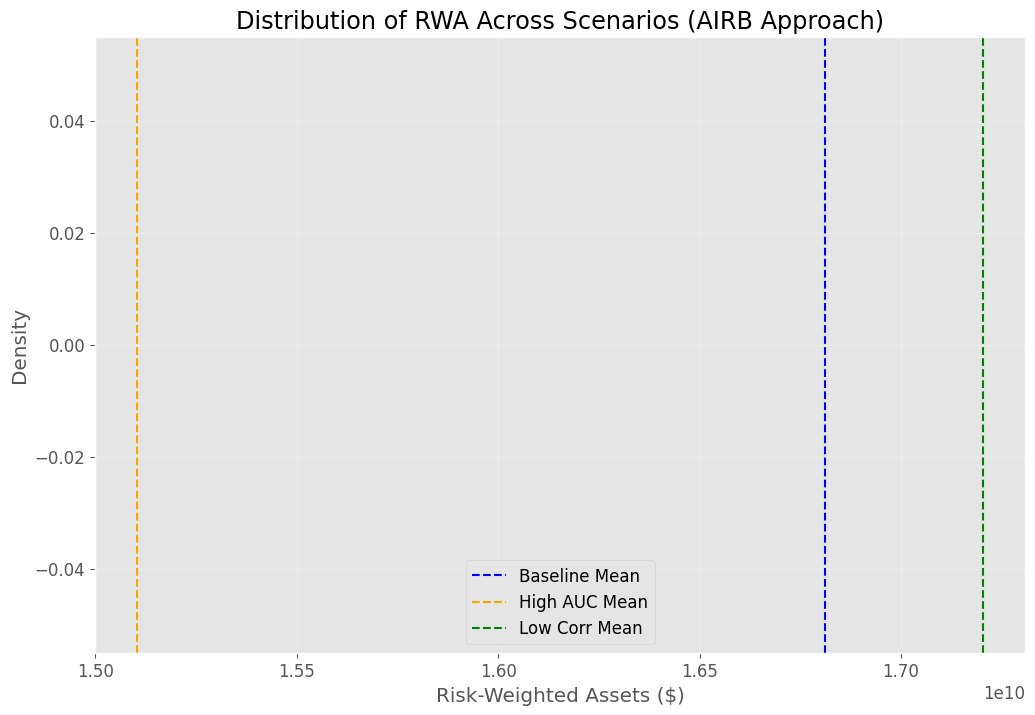

In [9]:
# Create a visualization of the RWA distributions
plt.figure(figsize=(12, 8))
sns.kdeplot(baseline_dist, label='Baseline', fill=True, alpha=0.3)
sns.kdeplot(high_auc_dist, label='High AUC (0.90)', fill=True, alpha=0.3)
sns.kdeplot(low_corr_dist, label='Low Correlation (0.15)', fill=True, alpha=0.3)

# Add vertical lines for the means
plt.axvline(baseline_airb_stats['mean'], color='blue', linestyle='--', label='Baseline Mean')
plt.axvline(high_auc_airb_stats['mean'], color='orange', linestyle='--', label='High AUC Mean')
plt.axvline(low_corr_airb_stats['mean'], color='green', linestyle='--', label='Low Corr Mean')

plt.title('Distribution of RWA Across Scenarios (AIRB Approach)')
plt.xlabel('Risk-Weighted Assets ($)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

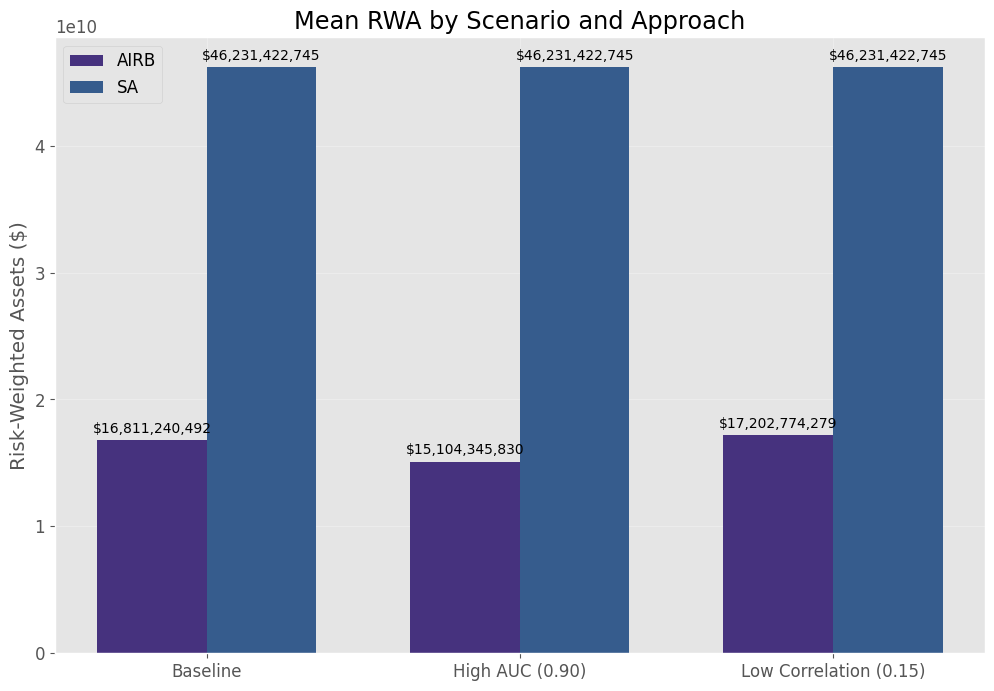

In [10]:
# Create a bar chart comparing mean RWA values
scenarios = ['Baseline', 'High AUC (0.90)', 'Low Correlation (0.15)']
airb_means = [baseline_airb_stats['mean'], high_auc_airb_stats['mean'], low_corr_airb_stats['mean']]
sa_means = [
    integrated_analysis.get_summary_stats('Baseline', 'SA')['mean'],
    integrated_analysis.get_summary_stats('High AUC (0.90)', 'SA')['mean'],
    integrated_analysis.get_summary_stats('Low Correlation (0.15)', 'SA')['mean']
]

x = np.arange(len(scenarios))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, airb_means, width, label='AIRB')
rects2 = ax.bar(x + width/2, sa_means, width, label='SA')

# Add labels and title
ax.set_ylabel('Risk-Weighted Assets ($)')
ax.set_title('Mean RWA by Scenario and Approach')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.legend()

# Add value labels on top of bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'${height:,.0f}',
                   xy=(rect.get_x() + rect.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center', va='bottom', fontsize=10)

add_labels(rects1)
add_labels(rects2)

plt.grid(True, alpha=0.3)
plt.show()

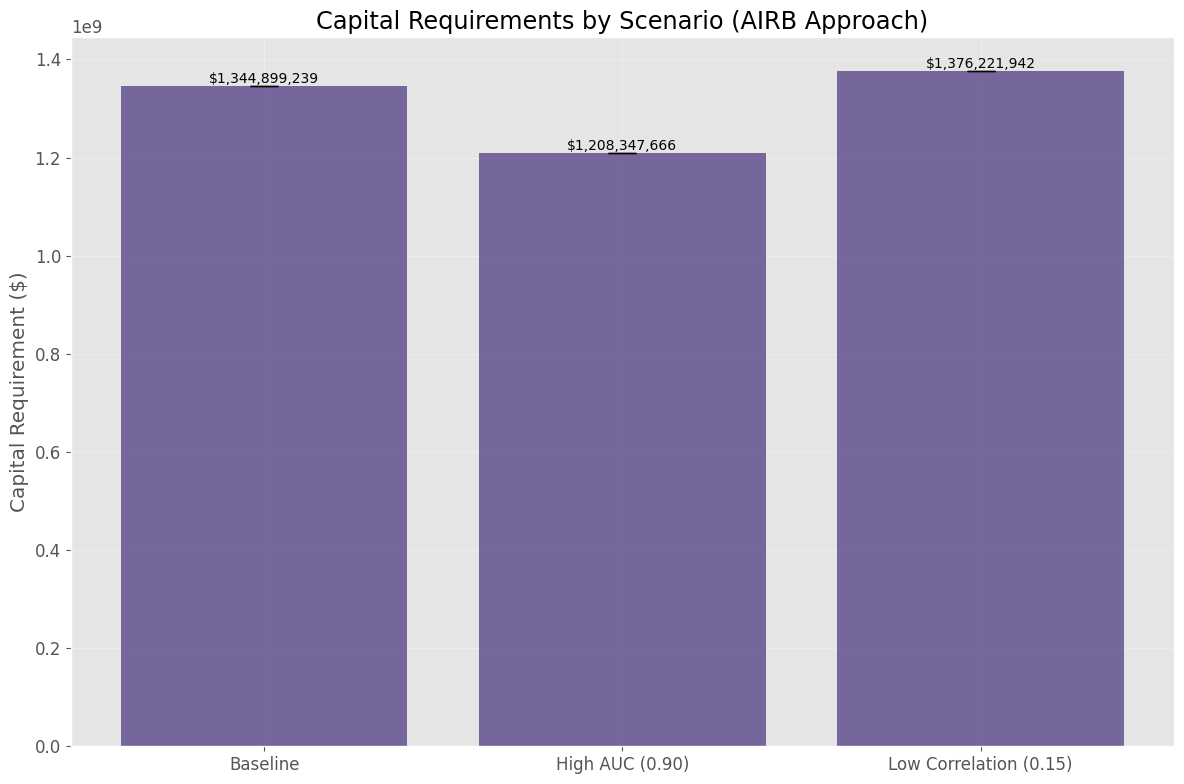

In [11]:
# Create a visualization of capital requirements with error bars
fig, ax = plt.subplots(figsize=(12, 8))

scenarios = ['Baseline', 'High AUC (0.90)', 'Low Correlation (0.15)']
capital_reqs = [stat['mean'] * 0.08 for stat in [baseline_airb_stats, high_auc_airb_stats, low_corr_airb_stats]]
stdevs = [stat['std'] * 0.08 for stat in [baseline_airb_stats, high_auc_airb_stats, low_corr_airb_stats]]

# Create bar chart with error bars
ax.bar(scenarios, capital_reqs, yerr=stdevs, alpha=0.7, capsize=10)

ax.set_title('Capital Requirements by Scenario (AIRB Approach)')
ax.set_ylabel('Capital Requirement ($)')
ax.grid(True, alpha=0.3)

# Add value labels on top of bars
for i, v in enumerate(capital_reqs):
    ax.text(i, v + stdevs[i] + 10000, f'${v:,.0f}', 
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 8. Sensitivity Analysis

Let's examine how AUC affects capital requirements by running a sensitivity analysis.

In [13]:
# Define a range of AUC values for sensitivity analysis
auc_values = [0.75, 0.85, 0.95]
auc_scenario_names = []

# Create and run scenarios for each AUC value
for auc in auc_values:
    scenario_name = f"AUC {auc:.2f}"
    auc_scenario_names.append(scenario_name)
    
    # Create a new simulator with this AUC
    auc_simulator = PortfolioSimulator(
        portfolio_df=portfolio_df.copy(),
        score_to_rating_bounds=score_to_rating_bounds,
        rating_col=rating_col,
        loan_id_col=loan_id_col,
        date_col=date_col,
        default_col=default_col,
        into_default_flag_col=into_default_flag_col,
        score_col=score_col,
        application_start_date=application_start_date,
        asset_correlation=0.15,
        target_auc=auc,
        random_seed=None
    )
    auc_simulator.prepare_simulation()
    
    # Add the scenario
    integrated_analysis.add_scenario(
        scenario_name,
        auc_simulator,
        n_iterations=3,  # Fewer iterations for demonstration
        description=f"Model with AUC of {auc:.2f}"
    )
    
    # Run the scenario with memory-efficient processing (critical for large datasets)
    print(f"Running scenario with AUC {auc:.2f} using memory-efficient processing...")
    integrated_analysis.run_scenario(scenario_name, memory_efficient=True)
    print(f"Completed scenario with AUC {auc:.2f}")

# Compare the scenarios
auc_comparison = integrated_analysis.compare_scenarios(auc_scenario_names, 'AIRB')
print("\nAUC Sensitivity Analysis:")
print(auc_comparison)

# Extract mean RWA and capital requirements for plotting
auc_rwa_means = [integrated_analysis.get_summary_stats(name, 'AIRB')['mean'] for name in auc_scenario_names]
auc_capital_reqs = [rwa * 0.08 for rwa in auc_rwa_means]

2025-09-29 17:01:35 - irbstudio.simulation.portfolio_simulator - INFO - Starting portfolio simulation preparation.
2025-09-29 17:01:35 - irbstudio.simulation.portfolio_simulator - INFO - Segmenting portfolio into historical and application samples.
2025-09-29 17:01:37 - irbstudio.simulation.portfolio_simulator - INFO - Historical sample size: 6069488; Application sample size: 2593086
2025-09-29 17:01:37 - irbstudio.simulation.portfolio_simulator - INFO - Segmenting application sample into new and existing clients.
2025-09-29 17:01:38 - irbstudio.simulation.portfolio_simulator - INFO - Existing clients: 2266470, New clients: 326616
2025-09-29 17:01:40 - irbstudio.simulation.portfolio_simulator - INFO - Fitting Beta Mixture Model to historical scores.
2025-09-29 17:01:40 - irbstudio.simulation.distribution - INFO - Supervised fitting complete.
2025-09-29 17:01:40 - irbstudio.simulation.distribution - INFO - Non-Default (C0): alpha=2.36, beta=431.43, weight=0.99
2025-09-29 17:01:40 - irbs

In [18]:
auc_rwa_std = [integrated_analysis.get_summary_stats(name, 'AIRB')['std'] for name in auc_scenario_names]

In [19]:
auc_rwa_std

[np.float64(32273238.867199667),
 np.float64(38900590.87469768),
 np.float64(138448500.69903585)]

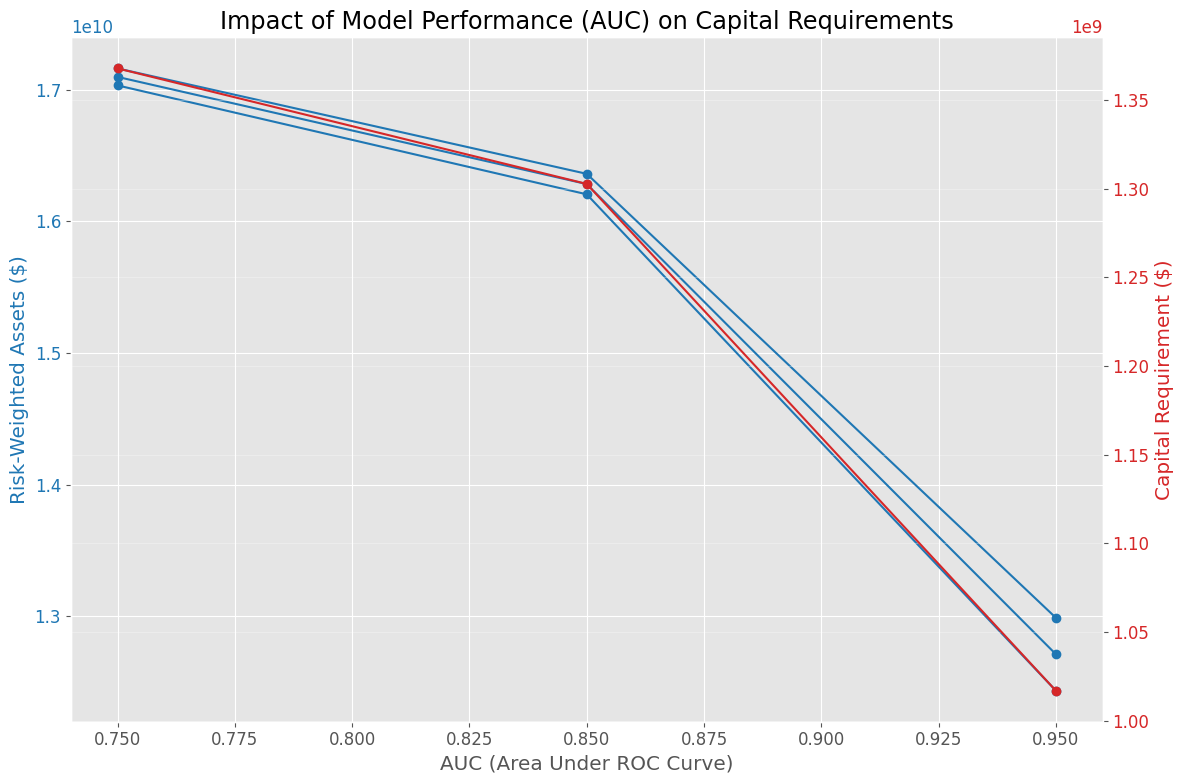

In [23]:
# Plot the relationship between AUC and capital requirements
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:blue'
ax1.set_xlabel('AUC (Area Under ROC Curve)')
ax1.set_ylabel('Risk-Weighted Assets ($)', color=color)
ax1.plot(auc_values, [x - 2*y for x, y in zip(auc_rwa_means,auc_rwa_std)], 'o-', color=color)
ax1.plot(auc_values, auc_rwa_means, 'o-', color=color)
ax1.plot(auc_values, [x + 2*y for x, y in zip(auc_rwa_means,auc_rwa_std)], 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for capital requirements
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Capital Requirement ($)', color=color)
ax2.plot(auc_values, auc_capital_reqs, 'o-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Impact of Model Performance (AUC) on Capital Requirements')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Extract Portfolio-Level Insights

Let's extract some detailed insights from one of the simulations to better understand what's happening at the portfolio level.

Portfolio Summary by Rating:
        Average PD  Average RW  Total Exposure     Total RWA  Exposure %  \
rating                                                                     
1         0.006267    0.215785    1.862282e+10  4.020157e+09   29.996668   
2         0.006577    0.221789    9.200056e+09  2.056112e+09   14.818973   
3         0.009722    0.278179    3.325094e+10  9.478874e+09   53.558894   
4         0.008465    0.254092    1.801142e+08  4.812451e+07    0.290119   
5         0.008177    0.249433    3.530926e+08  8.860446e+07    0.568743   
6         0.009966    0.279388    1.292163e+08  3.622856e+07    0.208135   
7         0.003385    0.158132    1.146574e+05  1.813098e+04    0.000185   
20        0.999900    3.125000    3.465990e+08  1.083122e+09    0.558284   

            RWA %  
rating             
1       23.913507  
2       12.230579  
3       56.384143  
4        0.286264  
5        0.527055  
6        0.215502  
7        0.000108  
20       6.442843  


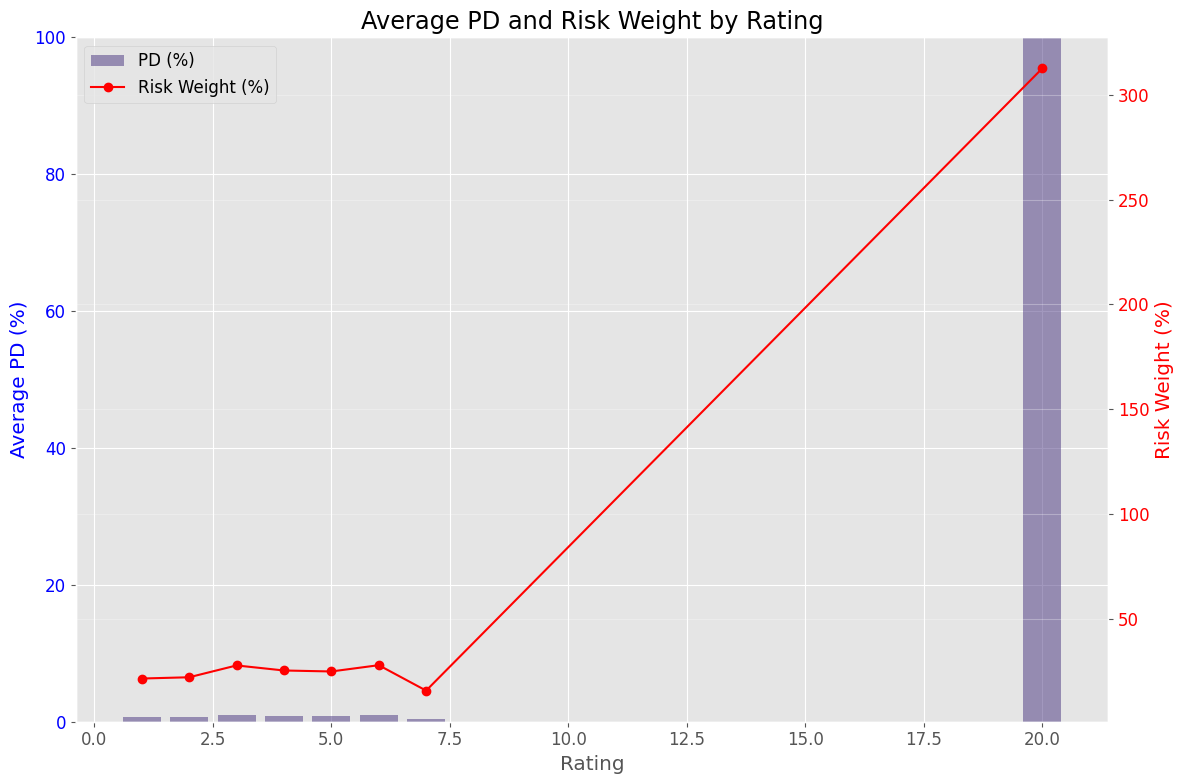

In [15]:
# Get a representative simulation result
baseline_results = integrated_analysis.results['Baseline']
airb_results = baseline_results['calculator_results']['AIRB']['results']

# Let's look at the first simulation result
if airb_results:
    result = airb_results[0]
    portfolio = result.portfolio
    
    # Calculate average PD and risk weight by rating
    pd_by_rating = portfolio.groupby('rating')['pd'].mean()
    rw_by_rating = portfolio.groupby('rating')['risk_weight'].mean()
    exposure_by_rating = portfolio.groupby('rating')['exposure'].sum()
    rwa_by_rating = portfolio.groupby('rating')['rwa'].sum()
    
    # Create a summary DataFrame
    rating_summary = pd.DataFrame({
        'Average PD': pd_by_rating,
        'Average RW': rw_by_rating,
        'Total Exposure': exposure_by_rating,
        'Total RWA': rwa_by_rating,
        'Exposure %': exposure_by_rating / exposure_by_rating.sum() * 100,
        'RWA %': rwa_by_rating / rwa_by_rating.sum() * 100
    })
    
    print("Portfolio Summary by Rating:")
    print(rating_summary)
    
    # Create a visualization of PD and RW by rating
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    # Plot average PD by rating (bar)
    pd_bars = ax1.bar(pd_by_rating.index, pd_by_rating * 100, alpha=0.5, label='PD (%)')
    ax1.set_xlabel('Rating')
    ax1.set_ylabel('Average PD (%)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_ylim(0, min(100, pd_by_rating.max() * 150))  # Cap at 100%
    
    # Create a second y-axis for risk weights
    ax2 = ax1.twinx()
    rw_line = ax2.plot(rw_by_rating.index, rw_by_rating * 100, 'o-', color='red', label='Risk Weight (%)')
    ax2.set_ylabel('Risk Weight (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Combine legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    
    plt.title('Average PD and Risk Weight by Rating')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 10. Compare AIRB and SA Approaches

Finally, let's compare the AIRB and SA approaches across all our scenarios.

In [ ]:
# Get summary statistics for all scenarios using both approaches
all_scenarios = ['Baseline', 'High AUC (0.90)', 'Low Correlation (0.10)'] + auc_scenario_names
airb_stats = [integrated_analysis.get_summary_stats(name, 'AIRB') for name in all_scenarios]
sa_stats = [integrated_analysis.get_summary_stats(name, 'SA') for name in all_scenarios]

# Extract mean RWA values
airb_means = [stat['mean'] for stat in airb_stats]
sa_means = [stat['mean'] for stat in sa_stats]

# Calculate the difference and ratio between approaches
differences = [airb - sa for airb, sa in zip(airb_means, sa_means)]
ratios = [airb / sa for airb, sa in zip(airb_means, sa_means)]

# Create a comparison DataFrame
approach_comparison = pd.DataFrame({
    'Scenario': all_scenarios,
    'AIRB RWA': airb_means,
    'SA RWA': sa_means,
    'Difference (AIRB - SA)': differences,
    'Ratio (AIRB / SA)': ratios
})

print("Comparison of AIRB and SA Approaches:")
print(approach_comparison)

# Create a visualization of AIRB/SA ratio by scenario
plt.figure(figsize=(12, 8))
plt.bar(approach_comparison['Scenario'], approach_comparison['Ratio (AIRB / SA)'], alpha=0.7)
plt.axhline(y=1.0, color='r', linestyle='-')
plt.title('Ratio of AIRB to SA RWA by Scenario')
plt.xlabel('Scenario')
plt.ylabel('AIRB / SA Ratio')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Conclusion

This notebook demonstrated how to use the `IntegratedAnalysis` class to integrate Monte Carlo simulations with RWA calculators for comprehensive risk and capital analysis.

Key insights from this analysis:

1. **Model Performance Impact** - Improving model discrimination (AUC) can lead to significant changes in capital requirements.

2. **Approach Comparison** - AIRB and SA approaches yield different capital requirements, with the ratio depending on portfolio composition and risk characteristics.

3. **Parameter Sensitivity** - Asset correlation has a notable effect on capital requirements, with lower correlation generally leading to lower capital.

4. **Distribution Analysis** - The distribution of RWA across simulations provides insights into tail risk and economic capital.

5. **Scenario Analysis** - Running multiple scenarios helps understand how different assumptions impact capital requirements.

The `IntegratedAnalysis` framework makes it easy to:
- Connect simulation engines with RWA calculators
- Run and compare multiple scenarios
- Calculate statistics across simulations
- Analyze sensitivity to model parameters
- Compare different regulatory approaches

This integrated approach provides a holistic view of credit risk and capital requirements under different scenarios.

## Memory Optimization for Large Datasets

This example demonstrates how to use the memory-efficient mode of the `IntegratedAnalysis` class. This is crucial when working with large datasets like the full Freddie Mac dataset with 10M+ rows.

### Problem

With a 10M row dataset, the standard approach would create:
- 60 copies of the dataset (3 scenarios × 20 iterations)
- ~30-60GB of memory usage
- Potential memory errors or system crashes

### Memory Optimization Techniques Implemented

1. **Single-Iteration Processing**: We process one Monte Carlo iteration at a time
   ```python
   # Instead of storing all simulations at once
   sim_df = simulator.run_monte_carlo(num_iterations=1, memory_efficient=True)[0]
   ```

2. **Immediate Calculation**: Each simulation is processed by calculators right away
   ```python
   # Calculate RWA for the current iteration only
   result = calculator.calculate(application_df)
   self.results[scenario_name]['calculator_results'][calc_name]['results'].append(result)
   ```

3. **Minimal Storage**: Only summary metrics are stored, not full DataFrames
   ```python
   # We store only RWA results, not the full portfolio
   rwa_values = [r.total_rwa for r in results if hasattr(r, 'total_rwa')]
   ```

4. **Garbage Collection**: Memory is explicitly freed between iterations
   ```python
   # Clean up to free memory
   del sim_df
   if iteration % 5 == 0:
       import gc
       gc.collect()
   ```

### Benefits

- **Reduced Memory Footprint**: Memory usage is nearly constant regardless of iterations
- **Sustainable Scaling**: Can handle datasets of virtually any size
- **Preserved Statistics**: All statistical metrics remain identical to the non-memory-efficient approach
- **Progress Tracking**: Regular progress updates during long-running simulations

### How to Use

Simply add `memory_efficient=True` to your `run_scenario` calls:

```python
# Memory-efficient simulation
results = integrated_analysis.run_scenario('Scenario Name', memory_efficient=True)
```

This approach is essential for production use with real-world mortgage portfolios that can contain millions of loans with multiple years of history.